# 머신러닝 기법을 활용한 보험 언더라이팅 모델 탐구 (포트폴리오 노트북 가이드)

아래 마크다운은 `prudential-life-insurance-assessment-python.ipynb`에 순서대로 추가할 설명문 초안입니다. 필요한 부분은 자유롭게 수정하세요.

## 1. 표지/초록

이 연구의 목적은 머신러닝 기법을 활용하여 보험 언더라이팅(인수심사) 과정을 자동화하고 효율성을 향상하는 모델을 구축하는 데 있다. Kaggle의 Prudential Life Insurance Assessment 대회의 데이터를 바탕으로, 가입 신청자의 언더라이팅 결과를 예측하는 모델을 설계하였다. 연구에 사용된 모델로는 로지스틱 회귀, 랜덤 포레스트, SVM, 부스팅 모델이 있다. 여러 평가지표에서 우수한 성능을 보인 모델은 부스팅 계열의 모델인 LightGBM이었다. 설명가능한 AI 기법 중 하나인 SHAP 를 활용하여 해당 모델의 설명 가능성 및 신뢰성을 보다 확보할 수 있었다. 본 연구는 머신러닝 모델이 보험사의 언더라이팅 과정을 간소화하고, 언더라이터의 업무 효율성을 높이는 데 기여할 수 있음을 시사한다.

## 2. 비즈니스 문제 정의

- 문제: 보험 언더라이팅(인수심사) 자동화 지원
- 목표: 다중 분류(클래스 1~8) 타깃 `Response` 예측
- 주요 지표: Accuracy, Macro-F1, Quadratic Weighted Kappa(QWK)

## 3. 데이터 소개

- 파일 구성: `data/train.csv`, `data/test.csv`, `data/sample_submission.csv`
- 경로 안내: 윈도우 환경 호환을 위해 노트북 내 `extract_path = 'data/'` 로 설정하세요.

## 4. EDA & 데이터 품질

- 타깃 분포 시각화, 누락치/이상치 점검
- 수치/범주형 특성 분포 비교 및 상관관계 확인

## 5. 전처리 설계

- 수치형: 결측치 중앙값 대체(선형계열에는 스케일링)
- 범주형: 최빈값 대체 + 원-핫 인코딩
- `ColumnTransformer`와 `Pipeline`을 사용해 모델별 전처리 일관 적용

## 6. 모델링 전략

- 후보 모델: 로지스틱 회귀, 랜덤 포레스트, SVM(RBF), LightGBM
- 검증: Stratified K-Fold(기본 5), 랜덤시드 고정으로 재현성 확보
- 지표: Accuracy, Macro-F1, QWK(커스텀 스코어러)

## 7. 하이퍼파라미터 튜닝(Optuna)

- LightGBM 중심 탐색: `num_leaves`, `max_depth`, `learning_rate`, `subsample`, `colsample_bytree`, `reg_alpha/lambda` 등
- CV 기반 목적함수 + Pruning으로 효율 개선

## 8. 결과 비교 & 선택

- 각 모델의 CV 성능(평균±표준편차) 표로 정리
- 최종 선택: LightGBM(성능/속도/해석가능성 균형)

## 9. 설명가능성(SHAP)

- 전역 중요도, 국소 사례 분석으로 정책적 해석 제공
- 업무 적용 관점: 리스크 요인 설명, 추가 심사 포인트 제시

## 10. 모델 저장 & 재현성

- 환경 및 라이브러리 버전 명시
- `joblib`으로 전처리+모델 저장, 입력 스키마 고정

## 11. Mock-up 시스템(Gradio)

- 입력(샘플 인덱스) → 예측 → SHAP 상위 특성 요약 → 한국어 설명문 출력
- 노트북 시연용으로 간단/안전하게 구성

## 12. 한계와 향후 과제

- 데이터 최신성/편향 관리, 규제·윤리 고려, 실무 플로우 결합
- 생성형 AI 연계: SHAP 요약 → 도메인 템플릿 기반 설명문 자동화(추후 확장)

### Code: 환경 설정 및 임포트

In [1]:
# 경로 추가(필요시) 및 재현성 시딩
import os, sys
sys.path.append(os.getcwd())

from src.config import seed_everything
from src.data import load_csvs, split_X_y
from src.models import make_pipelines
from src.metrics import evaluate_multiclass
from src.preprocess import build_preprocessor_from_df
from src.tuning import tune_lightgbm
from src.shap_utils import top_contributors_for_instance
from src.mockup_app import launch_demo_with_dataset

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
import pandas as pd

seed_everything(42)

### Code: 데이터 로드 및 분리

In [2]:
train_df, test_df, sample_df = load_csvs()  # data/ 경로 사용
X, y = split_X_y(train_df)
X.shape, y.shape

((59381, 127), (59381,))

### Code: 베이스라인 모델 비교 (5-Fold, QWK 포함)

In [3]:
pipelines = make_pipelines(train_df)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, pipe in pipelines.items():
    y_pred = cross_val_predict(pipe, X, y, cv=cv, n_jobs=-1)
    results[name] = evaluate_multiclass(y, y_pred)

pd.DataFrame([{**{"model": k}, **{m: v for m, v in vals.items() if m in ("accuracy", "macro_f1", "qwk")}} for k, vals in results.items()])

,model,accuracy,macro_f1,qwk
0,logistic_regression,0.521867,0.433929,0.535045
1,random_forest,0.573938,0.498472,0.520363
2,svm_rbf,0.489264,0.423816,0.534045
3,lightgbm,0.588572,0.513660,0.568798


### Code: LightGBM 하이퍼파라미터 튜닝 (Optuna)

In [4]:
best_model, best_params = tune_lightgbm(train_df, X, y, n_trials=30, n_splits=5)
best_params

[I 2025-08-09 09:27:07,291] A new study created in memory with name: no-name-22544f71-54dd-42c4-ae8a-5c453f92780c


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-08-09 09:28:22,131] Trial 0 finished with value: 0.5656248860704002 and parameters: {'n_estimators': 793, 'learning_rate': 0.012879463177851413, 'num_leaves': 49, 'max_depth': 12, 'min_child_samples': 93, 'subsample': 0.7918484426563392, 'colsample_bytree': 0.7278523588077424, 'reg_alpha': 0.011148558599964624, 'reg_lambda': 0.0022259229912592474}. Best is trial 0 with value: 0.5656248860704002.
[I 2025-08-09 09:30:28,328] Trial 1 finished with value: 0.5594322937513573 and parameters: {'n_estimators': 1194, 'learning_rate': 0.10935806487843447, 'num_leaves': 75, 'max_depth': 10, 'min_child_samples': 96, 'subsample': 0.5434287780255735, 'colsample_bytree': 0.5876221310177308, 'reg_alpha': 2.3759756100844712e-06, 'reg_lambda': 0.07043951703394873}. Best is trial 0 with value: 0.5656248860704002.
[I 2025-08-09 09:33:00,213] Trial 2 finished with value: 0.5660071158628075 and parameters: {'n_estimators': 1187, 'learning_rate': 0.03321350377249223, 'num_leaves': 93, 'max_depth': 13

{'n_estimators': 1463,
 'learning_rate': 0.03540810842732665,
 'num_leaves': 192,
 'max_depth': 7,
 'min_child_samples': 70,
 'subsample': 0.7398854358192757,
 'colsample_bytree': 0.9813604177913915,
 'reg_alpha': 0.004122450849938904,
 'reg_lambda': 8.796060496626285e-05,
 'objective': 'multiclass',
 'num_class': 8,
 'random_state': 42}

### Code: 최종 파이프라인 적합 및 SHAP 기여도 예시

In [10]:
pre_tree = build_preprocessor_from_df(train_df, for_linear=False)
final_pipe = Pipeline([("pre", pre_tree), ("clf", best_model)])
final_pipe.fit(X, y)

info = top_contributors_for_instance(final_pipe, X, index=0, top_k=5)
info

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3272
[LightGBM] [Info] Number of data points in the train set: 59381, number of used features: 142
[LightGBM] [Info] Start training from score -2.258297
[LightGBM] [Info] Start training from score -2.204204
[LightGBM] [Info] Start training from score -4.071058
[LightGBM] [Info] Start training from score -3.727699
[LightGBM] [Info] Start training from score -2.391667
[LightGBM] [Info] Start training from score -1.665118
[LightGBM] [Info] Start training from score -2.001163
[LightGBM] [Info] Start training from score -1.114124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\Users\dud40\Documents\GitHub\prudential-life-insurance-assessment-python\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


{'index': 0,
 'pred_class': 8,
 'top_features': [('num__Ins_Age', -0.013498478810219613),
  ('num__Ht', 0.007698271189005764),
  ('num__Product_Info_6', -0.004938458237046421),
  ('num__Product_Info_5', 0.0028832168202121795),
  ('num__Product_Info_7', -0.002030779750742193)],
 'probs': array([1.93750717e-02, 9.72927726e-03, 7.66427962e-07, 1.88837765e-04,
        4.71461284e-03, 3.15579119e-02, 3.55348507e-02, 8.98898671e-01])}

### Code: Gradio Mock-up 데모 (원할 때 실행)

In [ ]:
# 주의: 실행 시 로컬 서버가 열리므로, 데모 확인 후 셀 정지/재시작이 필요할 수 있습니다.
launch_demo_with_dataset(final_pipe, X)

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


c:\Users\dud40\Documents\GitHub\prudential-life-insurance-assessment-python\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\dud40\Documents\GitHub\prudential-life-insurance-assessment-python\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
from src.persist import save_pipeline

save_path = "artifacts/final_pipe.joblib"  # 경로는 자유롭게 지정
saved = save_pipeline(final_pipe, save_path)
print("Saved to:", saved)

Saved to: c:\Users\dud40\Documents\GitHub\prudential-life-insurance-assessment-python\artifacts\final_pipe.joblib


In [ ]:
from src.data import load_train, split_features_target
from src.persist import load_pipeline, load_and_prime
from src.mockup_app import launch_demo_with_dataset

# X 로드
df = load_train()               # data/train.csv
X, y = split_features_target(df)

# 저장된 파이프라인 로드 (LightGBM 전용)
# pipe = load_pipeline("artifacts/final_pipe.joblib")
# 또는 로드 + 캐시 프라임
pipe = load_and_prime("artifacts/final_pipe.joblib", X)

# Gradio 데모 실행
launch_demo_with_dataset(pipe, X)

ImportError: cannot import name 'load_train' from 'src.data' (c:\Users\dud40\Documents\GitHub\prudential-life-insurance-assessment-python\src\data.py)

## 데이터 불러오기

In [ ]:
import pandas as pd
import os

# 압축 해제된 CSV 파일들의 경로 설정
extract_path = 'data/'

train_csv = os.path.join(extract_path, 'train.csv')
test_csv = os.path.join(extract_path, 'test.csv')
sample_submission_csv = os.path.join(extract_path, 'sample_submission.csv')

# 데이터 로드
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)
sample_submission_df = pd.read_csv(sample_submission_csv)

# 데이터 크기 확인
print("Train DataFrame Shape:", train_df.shape)
print("Test DataFrame Shape:", test_df.shape)
print("Sample Submission DataFrame Shape:", sample_submission_df.shape)

# 데이터 샘플 확인
print("\nTrain DataFrame Head:")
print(train_df.head())

print("\nTest DataFrame Head:")
print(test_df.head())

print("\nSample Submission DataFrame Head:")
print(sample_submission_df.head())

Train DataFrame Shape: (59381, 128)
Test DataFrame Shape: (19765, 127)
Sample Submission DataFrame Shape: (19765, 2)

Train DataFrame Head:
   Id  Product_Info_1 Product_Info_2  Product_Info_3  Product_Info_4  \
0   2               1             D3              10        0.076923   
1   5               1             A1              26        0.076923   
2   6               1             E1              26        0.076923   
3   7               1             D4              10        0.487179   
4   8               1             D2              26        0.230769   

   Product_Info_5  Product_Info_6  Product_Info_7   Ins_Age        Ht  ...  \
0               2               1               1  0.641791  0.581818  ...   
1               2               3               1  0.059701  0.600000  ...   
2               2               3               1  0.029851  0.745455  ...   
3               2               3               1  0.164179  0.672727  ...   
4               2               3    

In [5]:
train_df['InsuredInfo_1'].value_counts()

InsuredInfo_1
1    47223
2    11886
3      272
Name: count, dtype: int64

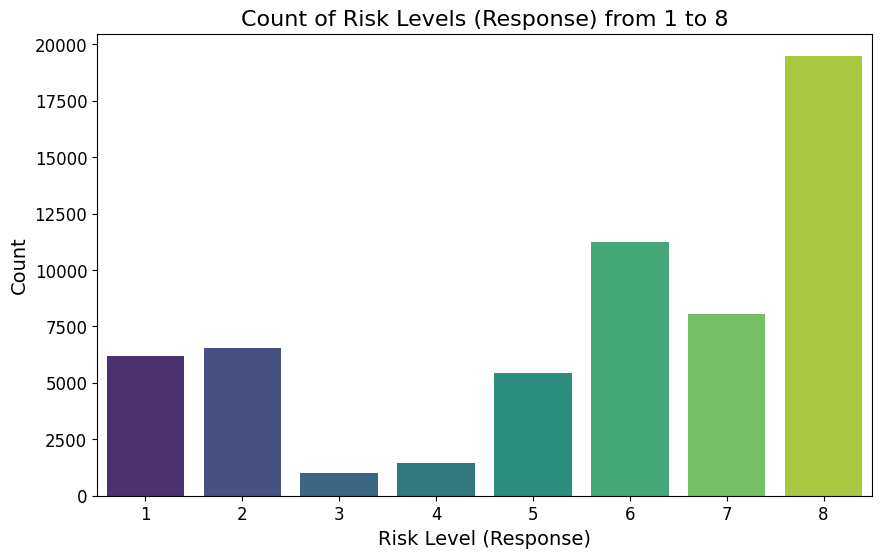

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Response 열의 카운트 값 계산
response_counts = train_df['Response'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=response_counts.index, y=response_counts.values, palette="viridis")
plt.title("Count of Decision Levels (Response) from 1 to 8", fontsize=16)
plt.xlabel("Decision Level (Response)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [7]:
# Response 변환 적용
train_df['Response'] = train_df['Response'].apply(lambda x: 1 if x == 1 else 0)

In [8]:
train_df['Response'].value_counts()

Response
0    53174
1     6207
Name: count, dtype: int64

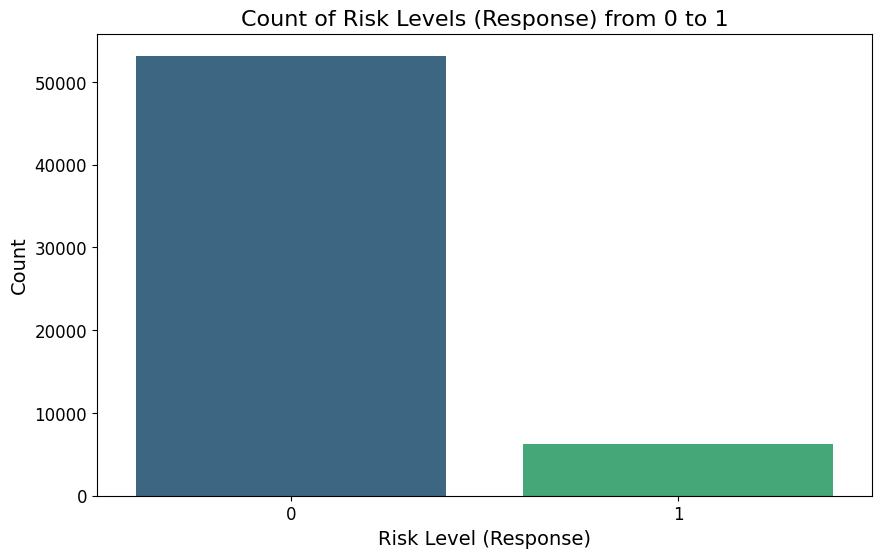

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Response 열의 카운트 값 계산
response_counts = train_df['Response'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=response_counts.index, y=response_counts.values, palette="viridis")
plt.title("Count of Decision Levels (Response) from 0 to 1", fontsize=16)
plt.xlabel("Decision Level (Response)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## 데이터 타입 변경

데이터 타입에 대한 결정 수행이 우선 요구됨. 고유 값이 40개 이하인 경우 범주형으로 구분함. 40개 이상의 값을 가진 경우 개별 변수에 대해서 값, 분포를 보고 판단함.

In [10]:
# 명목형 변수 리스트 (categorical)
categorical_vars = [
    'Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_5', 
    'Product_Info_6', 'Product_Info_7', 'Employment_Info_2', 'Employment_Info_3', 
    'Employment_Info_5', 'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 
    'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_7', 
    'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 
    'Insurance_History_4', 'Insurance_History_7', 'Insurance_History_8', 
    'Insurance_History_9', 'Family_Hist_1', 'Medical_History_2', 
    'Medical_History_3', 'Medical_History_4', 'Medical_History_5', 
    'Medical_History_6', 'Medical_History_7', 'Medical_History_8', 
    'Medical_History_9', 'Medical_History_11', 'Medical_History_12', 
    'Medical_History_13', 'Medical_History_14', 'Medical_History_16', 
    'Medical_History_17', 'Medical_History_18', 'Medical_History_19', 
    'Medical_History_20', 'Medical_History_21', 'Medical_History_22', 
    'Medical_History_23', 'Medical_History_25', 'Medical_History_26', 
    'Medical_History_27', 'Medical_History_28', 'Medical_History_29', 
    'Medical_History_30', 'Medical_History_31', 'Medical_History_33', 
    'Medical_History_34', 'Medical_History_35', 'Medical_History_36', 
    'Medical_History_37', 'Medical_History_38', 'Medical_History_39', 
    'Medical_History_40', 'Medical_History_41'
]

# 연속형 변수 리스트 (continuous)
continuous_vars = [
    'Product_Info_4', 'Ins_Age', 'Ht', 'Wt', 'BMI', 'Employment_Info_1', 
    'Employment_Info_4', 'Employment_Info_6', 'Insurance_History_5', 
    'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5'
]

# 이산형 변수 리스트 (discrete)
discrete_vars = [
    'Medical_History_1', 'Medical_History_10', 'Medical_History_15', 
    'Medical_History_24', 'Medical_History_32'
]

# 더미 변수 리스트 (dummy variables)
dummy_vars = [f'Medical_Keyword_{i}' for i in range(1, 49)]

In [11]:
import pandas as pd

def convert_data_types(df, categorical_vars, continuous_vars, discrete_vars, dummy_vars):
    """
    데이터프레임의 열 타입을 지정된 변수 그룹에 따라 변환합니다.
    
    Parameters:
    - df (pd.DataFrame): 데이터 타입을 변환할 데이터프레임
    - categorical_vars (list): 명목형 변수 목록
    - continuous_vars (list): 연속형 변수 목록
    - discrete_vars (list): 이산형 변수 목록
    - dummy_vars (list): 더미 변수 목록 (0/1)
    
    Returns:
    - pd.DataFrame: 타입 변환이 완료된 데이터프레임
    """
    # 명목형 변수 변환
    if categorical_vars:
        df[categorical_vars] = df[categorical_vars].astype('category')
    
    # 연속형 변수 변환
    if continuous_vars:
        df[continuous_vars] = df[continuous_vars].astype('float')
    
    # 이산형 변수 변환
    if discrete_vars:
        df[discrete_vars] = df[discrete_vars].replace([float('inf'), float('-inf')], float('nan'))  # 무한값 처리
        df[discrete_vars] = df[discrete_vars].fillna(0).astype('float')  # NaN 처리 후 float 변환
    
    # 더미 변수 변환
    if dummy_vars:
        df[dummy_vars] = df[dummy_vars].astype('int32')
    
    # 변환 결과 반환
    return df

In [12]:
train_df = convert_data_types(train_df, categorical_vars, continuous_vars, discrete_vars, dummy_vars)

In [13]:
train_df = train_df.drop('Id', axis=1)

## 결측값 처리 및 데이터 변환

`Medical_History`, `Employment_Info`, `Insurance_History` 와 관련한 변수들은 Yeo-Johnson 변환을 수행함.

Missing data 처리는 아래 사항에 대한 판단부터 수행함.

    MCAR (Missing Completely At Random) - 완전히 무작위로 결측
    MAR (Missing At Random) - 무작위 아님
    MNAR (Missing Not At Random) - 무작위가 아님
    
MCAR의 여부는 Little's MCAR 테스트를 수행하여 알 수 있음. MAR, MNAR의 구분은 도메인 지식을 기반하여 구분하는 것이 일반적임.

데이터는 크게 아래와 같이 구분됨. 대분류 내의 변수 간에서만 Missing 여부에 상관관계가 있는 것인지 파악 필요함.

| **Variable** | **Description** |
| --- | --- |
| Id | A unique identifier associated with an application. |
| Product_Info_1-7 | A set of normalized variables relating to the product applied for |
| Ins_Age | Normalized age of applicant |
| Ht | Normalized height of applicant |
| Wt | Normalized weight of applicant |
| BMI | Normalized BMI of applicant |
| Employment_Info_1-6 | A set of normalized variables relating to the employment history of the applicant. |
| InsuredInfo_1-6 | A set of normalized variables providing information about the applicant. |
| Insurance_History_1-9 | A set of normalized variables relating to the insurance history of the applicant. |
| Family_Hist_1-5 | A set of normalized variables relating to the family history of the applicant. |
| Medical_History_1-41 | A set of normalized variables relating to the medical history of the applicant. |
| Medical_Keyword_1-48 | A set of dummy variables relating to the presence of/absence of a medical keyword being associated with the application. |
| Response | This is the target variable, an ordinal variable relating to the final decision associated with an application |

In [14]:
import pandas as pd

def missing_values_table(df, dropna=True, sort=True, ascending=False, top=None):
    """
    데이터프레임의 각 열에 대한 결측값 수와 비율을 계산하여 반환합니다.

    Parameters:
    -----------
    df : pandas.DataFrame
        분석할 데이터프레임.
    
    dropna : bool, default=True
        True인 경우, 결측값이 없는 열을 제외합니다.
    
    sort : bool, default=True
        True인 경우, 결측값 비율에 따라 내림차순으로 정렬합니다.
    
    ascending : bool, default=False
        sort가 True일 때, 정렬 순서를 결정합니다. False는 내림차순, True는 오름차순.
    
    top : int, default=None
        상위 N개의 결과만 표시합니다. None인 경우, 모든 결과를 표시합니다.
    
    Returns:
    --------
    missing_data : pandas.DataFrame
        각 열의 결측값 수와 비율을 포함한 데이터프레임.
    
    Examples:
    ---------
    >>> missing_values_table(df)
    >>> missing_values_table(df, dropna=False, sort=False)
    >>> missing_values_table(df, top=10)
    """
    # 전체 행 수 계산
    total = df.shape[0]
    
    # 각 열의 결측값 수 계산
    missing_counts = df.isnull().sum()
    
    # 각 열의 결측값 비율 계산
    missing_percent = (missing_counts / total) * 100
    
    # 결과를 데이터프레임으로 통합
    missing_data = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing Percentage (%)': missing_percent
    })
    
    # 결측값이 있는 열만 필터링 (dropna=True인 경우)
    if dropna:
        missing_data = missing_data[missing_data['Missing Count'] > 0]
    
    # 정렬 (sort=True인 경우)
    if sort:
        missing_data = missing_data.sort_values(by='Missing Percentage (%)', ascending=ascending)
    
    # 상위 N개만 표시 (top 지정한 경우)
    if top is not None:
        missing_data = missing_data.head(top)
    
    return missing_data

In [15]:
missing_data = missing_values_table(train_df)

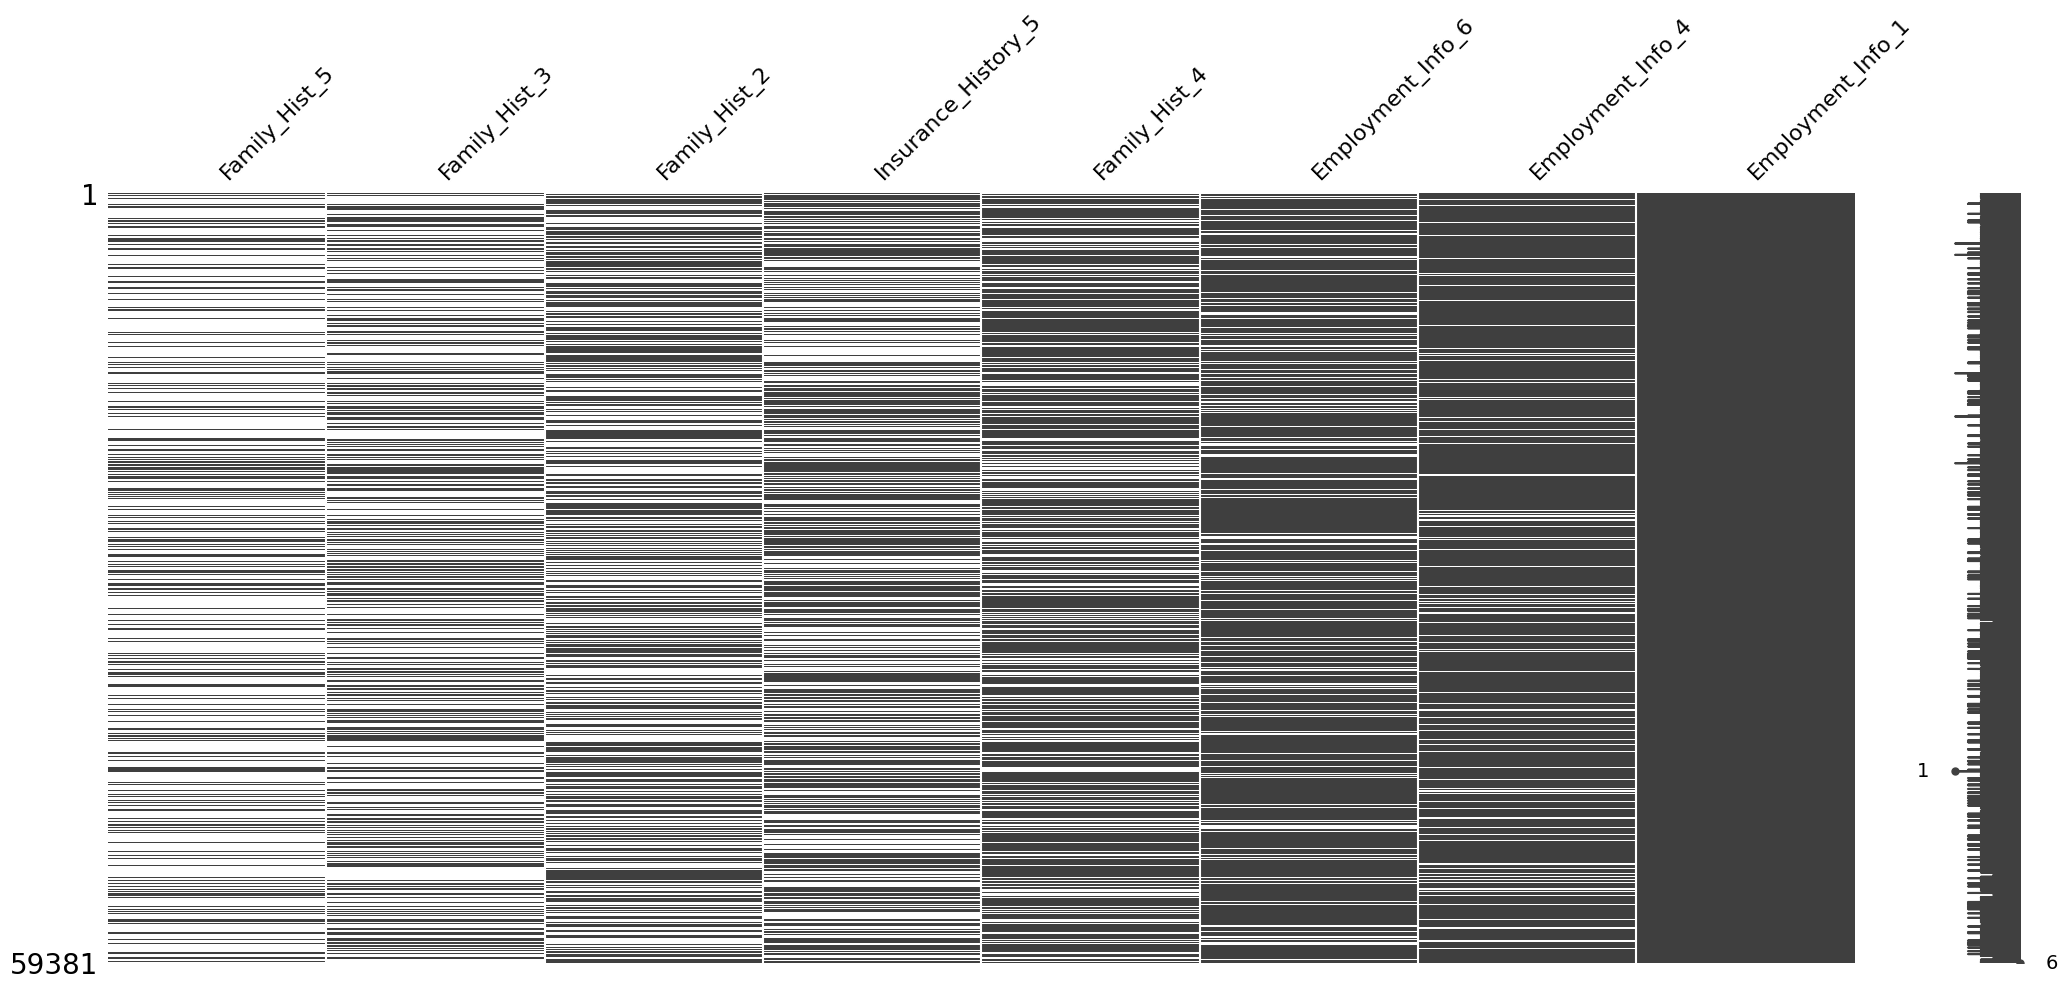

In [16]:
import missingno as msno
import matplotlib.pyplot as plt

missing_cols = missing_data.index.values

# 결측치 히트맵
msno.matrix(train_df[missing_cols])
plt.show()

Family_Hist 변수 간 Missing 에는 상관관계가 있는 것처럼 보임.

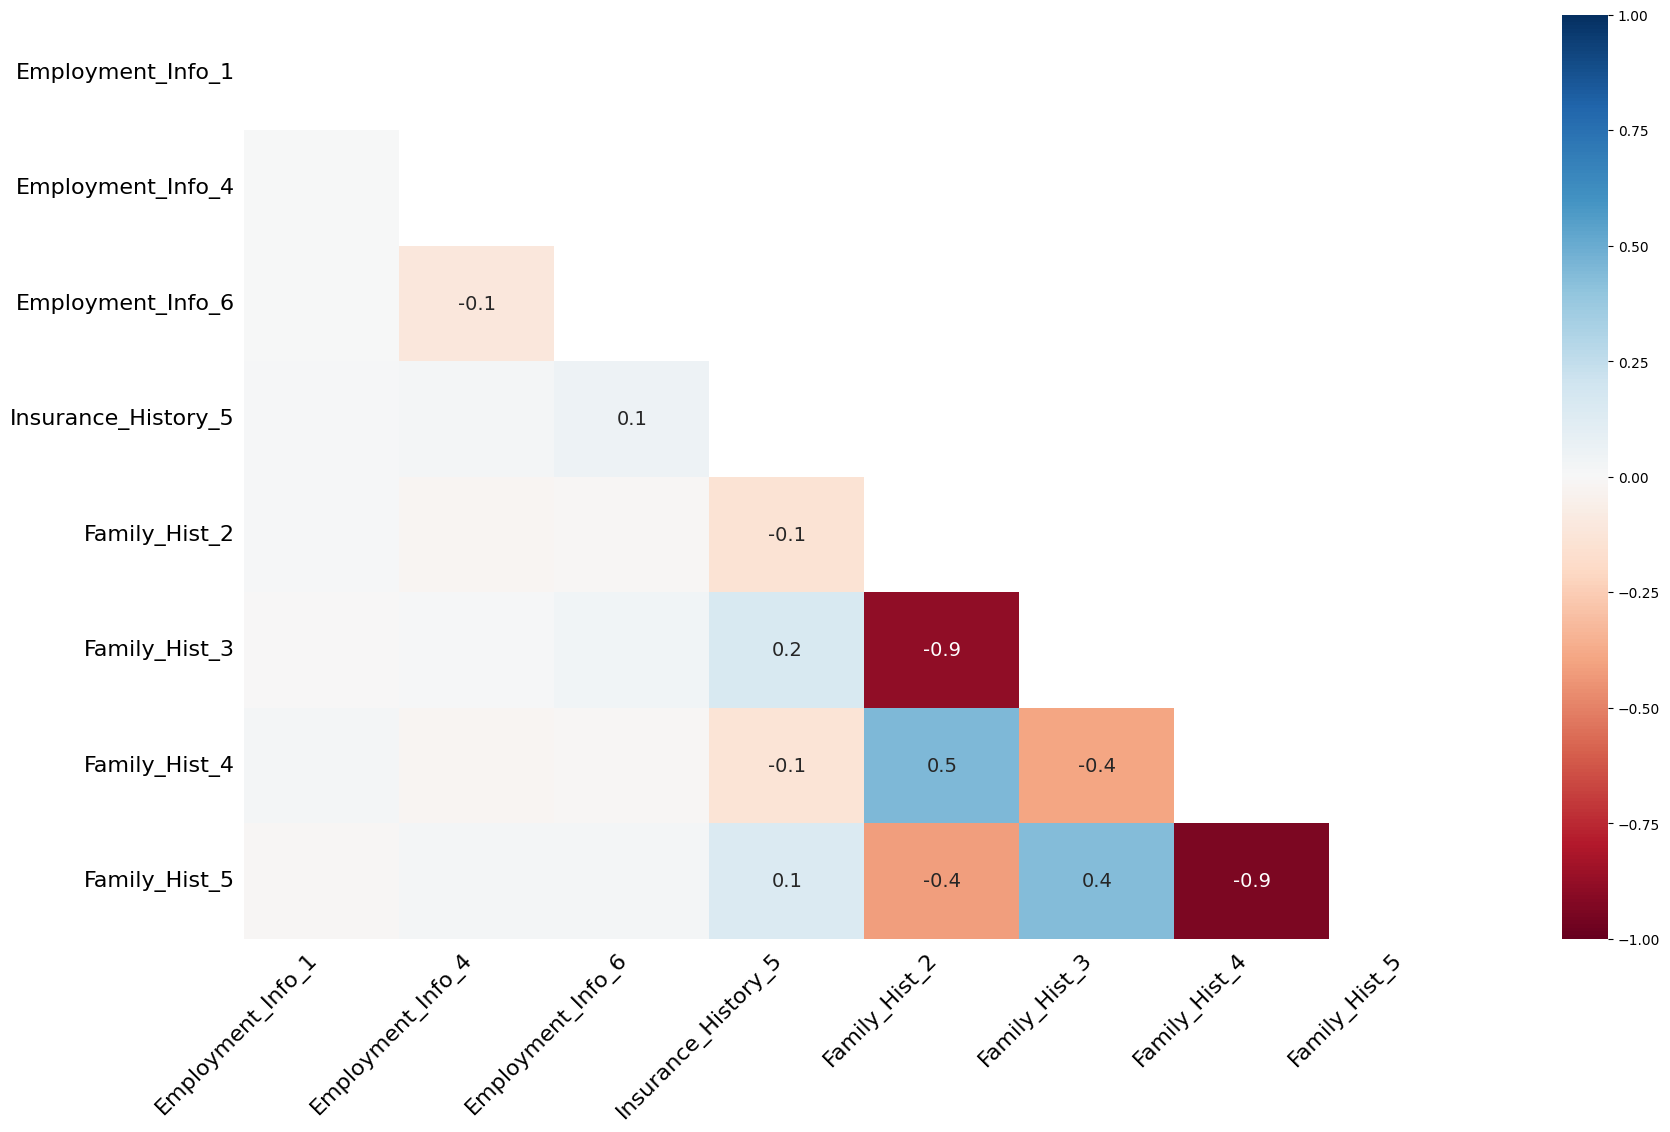

In [17]:
# 결측치 상관관계 히트맵
msno.heatmap(train_df)
plt.show()

    Employment_Info_1: 중간값 대체
    Family_Hist_1~5, Insurance_History_5, Employment_Info_4, Employment_Info_6, Medical_History_1 : MICE 대체


In [18]:
# 불필요한 열 제거
X_train_full = train_df.drop(['Response'], axis=1)
y_train = train_df['Response']

In [19]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import PowerTransformer
import sklearn

# 1. 결측치 대체를 위한 열 그룹화
knn_impute_cols = ['Employment_Info_1', 'Employment_Info_4', 'Employment_Info_6']
mice_impute_cols = [
    'Family_Hist_1', 'Family_Hist_2', 'Family_Hist_3',
    'Family_Hist_4', 'Family_Hist_5', 'Insurance_History_5'
]

# 2. Imputer 정의
knn_imputer = KNNImputer(n_neighbors=2)
mice_imputer = IterativeImputer(random_state=0)
# Yeo-Johnson 변환기
# yeo_johnson_transformer = PowerTransformer(method='yeo-johnson')

# 3. ColumnTransformer 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('knn_impute', knn_imputer, knn_impute_cols),
        ('mice_impute', mice_imputer, mice_impute_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False  # scikit-learn 1.2+에서 사용 가능
)

# 4. 전체 Pipeline 설정
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# 5. 파이프라인을 데이터에 적용
X_train_imputed = pipeline.fit_transform(X_train_full)

# 6. 결과를 데이터프레임으로 변환
if sklearn.__version__ >= '1.2':
    feature_names = preprocessor.get_feature_names_out()
else:
    try:
        feature_names = preprocessor.get_feature_names()
    except AttributeError:
        feature_names = X_train_full.columns  # 임시로 원본 열 이름 사용
        
# 7. 데이터프레임으로 변환
X_train_imputed = pd.DataFrame(X_train_imputed, columns=feature_names)
# 원본 열 순서대로 재정렬
X_train_imputed = X_train_imputed[X_train_full.columns]

In [20]:
X_train_imputed = convert_data_types(X_train_imputed, categorical_vars, continuous_vars, discrete_vars, dummy_vars)

/tmp/ipykernel_207/1925768960.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[discrete_vars] = df[discrete_vars].replace([float('inf'), float('-inf')], float('nan'))  # 무한값 처리


In [21]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')

# Fit the encoder on the train data and transform
encoded_train = encoder.fit_transform(X_train_imputed[categorical_vars])

# Convert encoded arrays back to DataFrame
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_vars))

# Add back non-categorical columns to the final DataFrame
X_train_encoded = pd.concat([X_train_imputed.reset_index(drop=True), encoded_train_df], axis=1).drop(columns=categorical_vars)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
# Results
print("Encoded Train DataFrame:")
print(X_train_encoded.shape)

Encoded Train DataFrame:
(59381, 835)


## 모델링

In [23]:
from sklearn.model_selection import train_test_split
# 1. 데이터 분할 (훈련 세트와 검증 세트)
X_train, X_val, y_train_split, y_val = train_test_split(
    X_train_encoded, y_train, test_size=0.2, random_state=42, stratify=y_train
)
print("\n학습 세트 특징 데이터의 형태:", X_train.shape)
print("검증 세트 특징 데이터의 형태:", X_val.shape)


학습 세트 특징 데이터의 형태: (47504, 835)
검증 세트 특징 데이터의 형태: (11877, 835)


In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score

def evaluate_model(model, X_test, y_test):
    """
    모델의 성능을 평가하고 결과를 출력합니다.

    Parameters:
    -----------
    model : sklearn 모델
        학습된 머신러닝 모델.
    X_test : pandas.DataFrame or numpy.ndarray
        테스트 세트의 특징 데이터.
    y_test : pandas.Series or numpy.ndarray
        테스트 세트의 실제 레이블.
    """
    # 예측 수행
    y_pred = model.predict(X_test)

    # Cohen's Kappa 계산
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # 평가 결과 출력
    print(f"\nCohen's Kappa (𝜅): {kappa:.4f}")
    print("\n혼동 행렬 (Confusion Matrix):")
    print(confusion_matrix(y_test, y_pred))
    print("\n분류 보고서 (Classification Report):")
    print(classification_report(y_test, y_pred))

In [31]:
import optuna 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [33]:
def objective(trial):
    # 하이퍼파라미터 공간 정의
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 110)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    
    # 모델 초기화
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'  # 클래스 불균형을 자동으로 처리
    )
    
    # 모델 학습
    rf.fit(X_train, y_train_split)
    
    # 예측
    y_pred = rf.predict(X_val)
    
    # 평가 지표 선택 (예: F1-score)
    score = cross_val_score(rf, X_train, y_train_split, cv=3, scoring='f1').mean()
    
    return score

# 스터디 생성 (TPE가 기본)
study = optuna.create_study(direction='maximize',  pruner=optuna.pruners.MedianPruner())

# 최적화 수행
study.optimize(objective, n_trials=10, timeout=600)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", study.best_params)
print("최고 정확도:", study.best_value)

[I 2024-11-30 07:21:51,690] A new study created in memory with name: no-name-ec98f914-8f68-45f1-b58e-a3a66dd4cba8
[I 2024-11-30 07:23:22,225] Trial 0 finished with value: 0.3033953082417446 and parameters: {'n_estimators': 387, 'max_depth': 58, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.3033953082417446.
[I 2024-11-30 07:26:24,398] Trial 1 finished with value: 0.18877236161804803 and parameters: {'n_estimators': 754, 'max_depth': 58, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.3033953082417446.
[I 2024-11-30 07:29:41,169] Trial 2 finished with value: 0.35731713479808414 and parameters: {'n_estimators': 1000, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.35731713479808414.
[I 2024-11-30 07:32:50,086] Trial 3 finished with value: 0.06044326593746548 and parameters: {'n_estimators': 730, 'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 2 with 

최적의 하이퍼파라미터: {'n_estimators': 1000, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 4}
최고 정확도: 0.35731713479808414


In [34]:
# 최적의 모델로 평가 수행
best_rf = RandomForestClassifier(
    n_estimators=study.best_params['n_estimators'],
    max_depth=study.best_params['max_depth'],
    min_samples_split=study.best_params['min_samples_split'],
    min_samples_leaf=study.best_params['min_samples_leaf'],
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

best_rf.fit(X_train, y_train_split)

evaluate_model(best_rf, X_val, y_val)


Cohen's Kappa (𝜅): 0.3126

혼동 행렬 (Confusion Matrix):
[[9798  838]
 [ 742  499]]

분류 보고서 (Classification Report):
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     10636
           1       0.37      0.40      0.39      1241

    accuracy                           0.87     11877
   macro avg       0.65      0.66      0.66     11877
weighted avg       0.87      0.87      0.87     11877



In [35]:
from sklearn.linear_model import LogisticRegression

def objective(trial):
    # 하이퍼파라미터 공간 정의
    C = trial.suggest_float('C', 1e-4, 1e4, log=True)
    
    # Logistic Regression 모델 초기화
    try:
        model = LogisticRegression(
            C=C,
            penalty='l1',
            solver='saga',
            class_weight='balanced',
            max_iter=1000,
            random_state=42,
            n_jobs=-1
        )
    except ValueError:
        # 일부 solver와 penalty 조합은 유효하지 않을 수 있음
        return -np.inf  # 최적화 과정에서 제외
    
    # 모델 학습
    model.fit(X_train, y_train_split)
    
    # 예측
    y_pred = model.predict(X_val)
    
    # 평가 지표 선택 (예: F1-score)
    score = cross_val_score(model, X_train, y_train_split, cv=3, scoring='f1').mean()
    
    return score

# 스터디 생성 (최대화를 목표로 함)
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())

# 최적화 수행
study.optimize(objective, n_trials=10, timeout=600)  # n_trials와 timeout은 필요에 따라 조정

[I 2024-11-30 07:33:59,042] A new study created in memory with name: no-name-ce981f1a-7dd3-4ebc-b66f-ef1f506d9f75
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-11-30 08:11:31,087] Trial 0 finished with value: 0.35295111972992205 and parameters: {'C': 3144.1478164542486}. Best is trial 0 with value: 0.35295111972992205.


In [36]:
# 최적의 하이퍼파라미터로 모델 재학습
best_params = study.best_params
best_lr = LogisticRegression(
    C=best_params['C'],
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    solver='saga',
    penalty='l1'
)

# 전체 학습 데이터로 재학습 (필요에 따라)
best_lr.fit(X_train, y_train_split)

# 모델 평가
print("\n로지스틱 회귀 모델 평가:")
evaluate_model(best_lr, X_val, y_val)


로지스틱 회귀 모델 평가:

Cohen's Kappa (𝜅): 0.2228

혼동 행렬 (Confusion Matrix):
[[7841 2795]
 [ 403  838]]

분류 보고서 (Classification Report):
              precision    recall  f1-score   support

           0       0.95      0.74      0.83     10636
           1       0.23      0.68      0.34      1241

    accuracy                           0.73     11877
   macro avg       0.59      0.71      0.59     11877
weighted avg       0.88      0.73      0.78     11877



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [56]:
from sklearn.svm import LinearSVC

def objective(trial):
    # 하이퍼파라미터 공간 정의
    C = trial.suggest_float('C', 1e-4, 1e4, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
        
    # LinearSVC 모델 초기화
    try:
        model = LinearSVC(
            C=C,
            loss=loss,
            class_weight='balanced',
            max_iter=max_iter,
            random_state=42
        )
    except ValueError:
        # 일부 하이퍼파라미터 조합은 유효하지 않을 수 있음
        return -np.inf  # Optuna가 이 시도를 무시하게 함
    
    # 모델 학습
    model.fit(X_train, y_train_split)
    
    # 예측
    y_pred = model.predict(X_val)
    
    # 평가 지표 선택 (예: F1-score)
    score = cross_val_score(model, X_train, y_train_split, cv=3, scoring='f1').mean()
    
    return score

# 스터디 생성 (최대화를 목표로 함)
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())

# 최적화 수행
study.optimize(objective, n_trials=10, timeout=600)  # n_trials와 timeout은 필요에 따라 조정

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", study.best_params)
print("최고 Cohen's Kappa:", study.best_value)

[I 2024-11-30 09:10:37,360] A new study created in memory with name: no-name-3578a003-77d1-4c6f-971e-2f30c7be4c3d
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2024-11-30 09:11:37,245] Trial 0 finished with value: 0.31779778625982386 and parameters: {'C': 0.8219290895367942, 'max_iter': 735, 'loss': 'squared_hinge'}. Best is trial 0 with value: 0.31779778625982386.

최적의 하이퍼파라미터: {'C': 0.009599625033528953, 'max_iter': 763, 'loss': 'hinge'}
최고 Cohen's Kappa: 0.3601433869757251


In [58]:
# 최적의 하이퍼파라미터로 모델 재학습
best_params = study.best_params
loss = best_params['loss']
C = best_params['C']
max_iter = best_params['max_iter']

best_svm = LinearSVC(
    C=C,
    loss=loss,
    class_weight='balanced',
    max_iter=max_iter,
    random_state=42
)

# 전체 학습 데이터로 재학습 (필요에 따라)
best_svm.fit(X_train, y_train_split)

# 모델 평가
print("\n최적화된 LinearSVC 모델 평가:")
evaluate_model(best_svm, X_val, y_val)

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



최적화된 LinearSVC 모델 평가:

Cohen's Kappa (𝜅): 0.2681

혼동 행렬 (Confusion Matrix):
[[8321 2315]
 [ 413  828]]

분류 보고서 (Classification Report):
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     10636
           1       0.26      0.67      0.38      1241

    accuracy                           0.77     11877
   macro avg       0.61      0.72      0.62     11877
weighted avg       0.88      0.77      0.81     11877



In [42]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from optuna.integration import LightGBMPruningCallback

def objective(trial):
    # 하이퍼파라미터 공간 정의
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 10.0),
        'class_weight':'balanced',
        'random_state': 42,
        'n_jobs': -1
    }
    
    # LGBMClassifier 모델 초기화
    model = LGBMClassifier(**param)

    model.fit(X_train, y_train_split)

    # 예측
    y_pred = model.predict(X_val)
    
    # 평가 지표 선택 (예: F1-score)
    score = cross_val_score(model, X_train, y_train_split, cv=3, scoring='f1').mean()
    
    return score


# 스터디 생성 (최대화를 목표로 함)
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())

# 최적화 수행
study.optimize(objective, n_trials=100, timeout=600, gc_after_trial=True)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", study.best_params)
print("최고 Cohen's Kappa:", study.best_value)

[I 2024-11-30 08:47:37,018] A new study created in memory with name: no-name-0c3cd14d-a35a-43a9-8dbb-88549d58c99f
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 10.0),
/tmp/ipykernel_207/16192916.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.sugge

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3821
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3310, number of negative: 28359
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3730
[LightGBM] [Info] Number of data points in the train set: 31669, number of used features: 228
[LightGBM] [Info] 

[I 2024-11-30 08:47:57,481] Trial 0 finished with value: 0.3216300423741973 and parameters: {'num_leaves': 60, 'learning_rate': 0.00033716268885035367, 'n_estimators': 262, 'max_depth': 13, 'min_child_samples': 59, 'subsample': 0.9053055420292151, 'colsample_bytree': 0.9630605733465796, 'reg_alpha': 0.003417717538838483, 'reg_lambda': 8.518115867148113}. Best is trial 0 with value: 0.3216300423741973.
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('r

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3957
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 302
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3310, number of negative: 28359
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3830
[LightGBM] [Info] Number of data points in the train set: 31669, number of used features: 278
[LightGBM] [Info] 

[I 2024-11-30 08:48:25,746] Trial 1 finished with value: 0.3299790258078243 and parameters: {'num_leaves': 32, 'learning_rate': 0.0009362137385174064, 'n_estimators': 599, 'max_depth': 7, 'min_child_samples': 22, 'subsample': 0.8583279333187162, 'colsample_bytree': 0.9875997814703725, 'reg_alpha': 0.0009204655409683934, 'reg_lambda': 0.020949455546106596}. Best is trial 1 with value: 0.3299790258078243.
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform(

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4067
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3310, number of negative: 28359
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3922
[LightGBM] [Info] Number of data points in the train set: 31669, number of used features: 324
[LightGBM] [Info] 

[I 2024-11-30 08:48:59,185] Trial 2 finished with value: 0.33750145280599303 and parameters: {'num_leaves': 60, 'learning_rate': 0.00028062409735248945, 'n_estimators': 531, 'max_depth': 9, 'min_child_samples': 11, 'subsample': 0.5754901494664377, 'colsample_bytree': 0.905577500869962, 'reg_alpha': 0.0009398627266842613, 'reg_lambda': 0.16348403072884785}. Best is trial 2 with value: 0.33750145280599303.
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3829
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 238
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-11-30 08:49:36,471] Trial 3 finished with value: 0.3649891410721895 and parameters: {'num_leaves': 71, 'learning_rate': 0.010033308161116403, 'n_estimators': 982, 'max_depth': 4, 'min_child_samples': 57, 'subsample': 0.802972011297996, 'colsample_bytree': 0.5667748241295927, 'reg_alpha': 0.0056912251951825804, 'reg_lambda': 0.02578009583831061}. Best is trial 3 with value: 0.3649891410721895.
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('re

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3831
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 239
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-11-30 08:49:55,005] Trial 4 finished with value: 0.3689191925217135 and parameters: {'num_leaves': 136, 'learning_rate': 0.019789220129385308, 'n_estimators': 644, 'max_depth': 4, 'min_child_samples': 56, 'subsample': 0.7220217436808724, 'colsample_bytree': 0.6658308273190046, 'reg_alpha': 0.01583301745607421, 'reg_lambda': 0.009276348117861004}. Best is trial 4 with value: 0.3689191925217135.
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('r

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4015
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 331
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3310, number of negative: 28359
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3876
[LightGBM] [Info] Number of data points in the train set: 31669, number of used features: 301
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[L

[I 2024-11-30 08:50:41,614] Trial 5 finished with value: 0.33978642995230884 and parameters: {'num_leaves': 34, 'learning_rate': 0.0003533833597326691, 'n_estimators': 953, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.8814554221052896, 'colsample_bytree': 0.5996583199446692, 'reg_alpha': 0.0009870281165602, 'reg_lambda': 0.9503192159971042}. Best is trial 4 with value: 0.3689191925217135.
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4267
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 457
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3310, number of negative: 28359
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4090
[LightGBM] [Info] Number of data points in the train set: 31669, number of used features: 408
[LightGBM] [Info] 

[I 2024-11-30 08:51:20,354] Trial 6 finished with value: 0.3857296793219645 and parameters: {'num_leaves': 89, 'learning_rate': 0.02298676855818934, 'n_estimators': 559, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.5030117551964458, 'colsample_bytree': 0.7819684113326709, 'reg_alpha': 4.312566195535685, 'reg_lambda': 0.0411536920991403}. Best is trial 6 with value: 0.3857296793219645.
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alp

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4015
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 331
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3310, number of negative: 28359
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3876
[LightGBM] [Info] Number of data points in the train set: 31669, number of used features: 301
[LightGBM] [Info] 

[I 2024-11-30 08:51:38,746] Trial 7 finished with value: 0.35509751381111787 and parameters: {'num_leaves': 116, 'learning_rate': 0.0003091227029614712, 'n_estimators': 187, 'max_depth': 14, 'min_child_samples': 15, 'subsample': 0.8753225070778552, 'colsample_bytree': 0.5751676318416554, 'reg_alpha': 0.3408469263491491, 'reg_lambda': 0.04111822322371448}. Best is trial 6 with value: 0.3857296793219645.
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3919
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 283
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 3310, number of negative: 28359
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3786
[LightGBM] [Info] Number of data points in the train set: 31669, number of used features: 256
[LightGBM] [Info] 

[I 2024-11-30 08:52:36,632] Trial 8 finished with value: 0.3704055200354314 and parameters: {'num_leaves': 78, 'learning_rate': 0.0042606162537624755, 'n_estimators': 780, 'max_depth': 15, 'min_child_samples': 30, 'subsample': 0.5548304365805067, 'colsample_bytree': 0.9131610129191154, 'reg_alpha': 0.000167881645514584, 'reg_lambda': 0.07867193246177683}. Best is trial 6 with value: 0.3857296793219645.
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3809
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 228
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-11-30 08:53:20,539] Trial 9 finished with value: 0.3643476685077047 and parameters: {'num_leaves': 139, 'learning_rate': 0.06370116685118636, 'n_estimators': 944, 'max_depth': 9, 'min_child_samples': 89, 'subsample': 0.9203478326475678, 'colsample_bytree': 0.9059827097606901, 'reg_alpha': 0.002620259937000954, 'reg_lambda': 1.5030198018851346}. Best is trial 6 with value: 0.3857296793219645.
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3877
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 262
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-11-30 08:53:47,027] Trial 10 finished with value: 0.38458002681752407 and parameters: {'num_leaves': 106, 'learning_rate': 0.09034348221471365, 'n_estimators': 361, 'max_depth': 12, 'min_child_samples': 38, 'subsample': 0.6623275269482314, 'colsample_bytree': 0.779941786813409, 'reg_alpha': 9.495680631026154, 'reg_lambda': 0.0006509932492067999}. Best is trial 6 with value: 0.3857296793219645.
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('r

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3869
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 258
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-11-30 08:54:13,677] Trial 11 finished with value: 0.3785208330224459 and parameters: {'num_leaves': 105, 'learning_rate': 0.093110012350837, 'n_estimators': 361, 'max_depth': 12, 'min_child_samples': 41, 'subsample': 0.6603086525307624, 'colsample_bytree': 0.7791690586011165, 'reg_alpha': 8.786099328010408, 'reg_lambda': 0.0003511717432748128}. Best is trial 6 with value: 0.3857296793219645.
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3811
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 229
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-11-30 08:54:40,063] Trial 12 finished with value: 0.3855782736078497 and parameters: {'num_leaves': 102, 'learning_rate': 0.025103121920884593, 'n_estimators': 431, 'max_depth': 11, 'min_child_samples': 82, 'subsample': 0.5019688158353851, 'colsample_bytree': 0.7822117305477305, 'reg_alpha': 7.3762694237231825, 'reg_lambda': 0.0006363411237684036}. Best is trial 6 with value: 0.3857296793219645.
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform(

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3811
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 229
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-11-30 08:55:08,265] Trial 13 finished with value: 0.3860137581634593 and parameters: {'num_leaves': 89, 'learning_rate': 0.019700363757741354, 'n_estimators': 480, 'max_depth': 11, 'min_child_samples': 81, 'subsample': 0.5058883880940592, 'colsample_bytree': 0.7003895630702268, 'reg_alpha': 0.5832603605414876, 'reg_lambda': 0.00442309591601469}. Best is trial 13 with value: 0.3860137581634593.
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('r

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3811
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 229
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-11-30 08:55:54,706] Trial 14 finished with value: 0.3718205773892312 and parameters: {'num_leaves': 89, 'learning_rate': 0.0039164925479433215, 'n_estimators': 742, 'max_depth': 10, 'min_child_samples': 75, 'subsample': 0.5896488173671093, 'colsample_bytree': 0.6960857192646192, 'reg_alpha': 0.6846394870251461, 'reg_lambda': 0.0045899367072665745}. Best is trial 13 with value: 0.3860137581634593.
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3807
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 227
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-11-30 08:56:16,704] Trial 15 finished with value: 0.3711752664588275 and parameters: {'num_leaves': 124, 'learning_rate': 0.011540339709257517, 'n_estimators': 469, 'max_depth': 7, 'min_child_samples': 99, 'subsample': 0.5091314913381768, 'colsample_bytree': 0.6985324400702189, 'reg_alpha': 0.30879373950410915, 'reg_lambda': 0.003024855630834683}. Best is trial 13 with value: 0.3860137581634593.
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform(

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3815
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 231
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-11-30 08:57:10,586] Trial 16 finished with value: 0.3589244157085159 and parameters: {'num_leaves': 92, 'learning_rate': 0.0013756435625151906, 'n_estimators': 712, 'max_depth': 10, 'min_child_samples': 74, 'subsample': 0.9792991303500012, 'colsample_bytree': 0.5047536912381179, 'reg_alpha': 1.268194727249424, 'reg_lambda': 0.2597298794923788}. Best is trial 13 with value: 0.3860137581634593.
/tmp/ipykernel_207/16192916.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/tmp/ipykernel_207/16192916.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('re

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3819
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 233
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3310, number of negative: 28359
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032085 seconds.
You can set `force_row_wise=true` to remove

[I 2024-11-30 08:57:49,584] Trial 17 finished with value: 0.38123410652772244 and parameters: {'num_leaves': 49, 'learning_rate': 0.03514888319028534, 'n_estimators': 842, 'max_depth': 13, 'min_child_samples': 67, 'subsample': 0.6377952751335954, 'colsample_bytree': 0.838653244175775, 'reg_alpha': 0.11587415842475925, 'reg_lambda': 0.002545868134702015}. Best is trial 13 with value: 0.3860137581634593.


최적의 하이퍼파라미터: {'num_leaves': 89, 'learning_rate': 0.019700363757741354, 'n_estimators': 480, 'max_depth': 11, 'min_child_samples': 81, 'subsample': 0.5058883880940592, 'colsample_bytree': 0.7003895630702268, 'reg_alpha': 0.5832603605414876, 'reg_lambda': 0.00442309591601469}
최고 Cohen's Kappa: 0.3860137581634593


In [45]:
# 최적의 하이퍼파라미터로 모델 재학습
best_params = study.best_params
best_params['class_weight'] = 'balanced'
best_params['random_state'] = 42
best_params['n_jobs'] = -1

best_lgbm = LGBMClassifier(**best_params)

# 전체 학습 데이터로 재학습
best_lgbm.fit(X_train, y_train_split)

[LightGBM] [Info] Number of positive: 4966, number of negative: 42538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3811
[LightGBM] [Info] Number of data points in the train set: 47504, number of used features: 229
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7003895630702268,
               learning_rate=0.019700363757741354, max_depth=11,
               min_child_samples=81, n_estimators=480, n_jobs=-1, num_leaves=89,
               random_state=42, reg_alpha=0.5832603605414876,
               reg_lambda=0.00442309591601469, subsample=0.5058883880940592)

In [46]:
# 모델 평가
print("\n최적화된 LGBMClassifier 모델 평가:")
evaluate_model(best_lgbm, X_val, y_val)


최적화된 LGBMClassifier 모델 평가:

Cohen's Kappa (𝜅): 0.3009

혼동 행렬 (Confusion Matrix):
[[8723 1913]
 [ 450  791]]

분류 보고서 (Classification Report):
              precision    recall  f1-score   support

           0       0.95      0.82      0.88     10636
           1       0.29      0.64      0.40      1241

    accuracy                           0.80     11877
   macro avg       0.62      0.73      0.64     11877
weighted avg       0.88      0.80      0.83     11877



In [59]:
import joblib

# 1. 모델들을 딕셔너리에 저장
models = {
    'best_svm': best_svm,
    'best_lgbm': best_lgbm,
    'best_lr': best_lr,
    'best_rf': best_rf
}

# 2. 각 모델을 반복적으로 저장
for name, model in models.items():
    filename = f'{name}.pkl'  # 파일명 설정
    joblib.dump(model, filename)  # 모델 저장
    print(f'{filename} 저장 완료')

best_svm.pkl 저장 완료
best_lgbm.pkl 저장 완료
best_lr.pkl 저장 완료
best_rf.pkl 저장 완료


## Shapley Value

In [ ]:
import shap

# TreeExplainer 생성
explainer = shap.TreeExplainer(best_rf, approximate=True)
shap_values = explainer.shap_values(X_val)

In [ ]:
# 이진 분류의 경우, 양성 클래스의 SHAP 값만 선택
shap_values_positive = shap_values[1]

In [ ]:
# SHAP 초기화 (Jupyter Notebook 사용 시)
shap.initjs()

# Summary Plot (Dot)
shap.summary_plot(shap_values_positive, X_val, plot_type="dot")

In [ ]:
# Summary Plot (Bar)
shap.summary_plot(shap_values_positive, X_val, plot_type="bar")

In [ ]:
# Dependence Plot 예시
shap.dependence_plot('BMI', shap_values_positive, X_val)

In [ ]:
best_lgbm.predict_proba(X_val)[:,1].argmin()

In [ ]:
X_val.iloc[4821]

In [ ]:
# Force Plot 예시 (첫 번째 인스턴스)
shap.force_plot(explainer.expected_value[1], shap_values_positive[4821], X_val.iloc[4821])

In [ ]:
X_val.iloc[2589]

In [ ]:
# Force Plot 예시 (첫 번째 인스턴스)
shap.force_plot(explainer.expected_value[1], shap_values_positive[2589], X_val.iloc[2589])

In [ ]:
# Waterfall Plot 예시 (첫 번째 인스턴스)
shap.waterfall_plot(shap.Explanation(values=shap_values_positive[0], 
                                     base_values=explainer.expected_value[1], 
                                     data=X_val.iloc[0]))

# 플롯 표시
plt.show()